# DA5401 Assignment 6 - Imputation via Regression

## Part A : Data Processing and Imputation

### Initial Imports and Data Load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,roc_auc_score,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("creditcard.csv")

print(df.columns)
print(df.shape)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')
(30000, 25)


Introducing MAR Values in 3 columns of the dataset

For MAR, the probability that a data point is missing depends on another column/ independent variable . If the probability is independent of the other column as well(i.e is a constant value like 5%, then it is said to be MCAR- Missing Completely At Random)

In [3]:
#id = df['ID']
#df = df.drop(columns=['ID'])

# Set seed - reproducability
np.random.seed(42)

# Introduce MAR
def introduce_mar_missingness(df, target_col, driver_col, intensity=0.08):
    """
    Introduce ~intensity proportion of MAR missingness in target_col based on driver_col.
    """
    driver = df[driver_col]
    # Logistic-style probability of missingness depending on driver
    p_missing = 1 / (1 + np.exp(-(driver - driver.mean()) / driver.std()))
    mask = np.random.rand(len(df)) < p_missing * intensity
    df.loc[mask, target_col] = np.nan
    return df

# Apply 
df_dirty = df.copy()
df_dirty = introduce_mar_missingness(df_dirty, 'LIMIT_BAL', 'AGE', intensity=0.08)
df_dirty = introduce_mar_missingness(df_dirty, 'BILL_AMT1', 'PAY_0', intensity=0.06)
df_dirty = introduce_mar_missingness(df_dirty, 'PAY_AMT1', 'BILL_AMT1', intensity=0.05)


#checking that Size is preserved
print(df_dirty.shape)

(30000, 25)


### Imputation Strategy 1(Baseline)

Replacing missing values with median of the column

In [4]:
df_A = df_dirty.copy()
for col in df_A.columns:
    if df_A[col].isna().any():
        df_A[col] =df_A[col].fillna(df_A[col].median())

print(df_A.isna().sum().sum()) #verifying that there are no null values

print(df_A.shape)

0
(30000, 25)


### Imputation Strategy 2: Regression Imputation(Linear)

We must select only the numeric data type columns, since categorical columns cant be handled by linear regression(obviously)


In [5]:
num_cols= df_dirty.select_dtypes(include = [np.number]).columns.tolist()

linear_imputer = IterativeImputer( estimator=LinearRegression(),random_state=42,max_iter=5,initial_strategy='median')

df_B = df_dirty.copy()
df_B[num_cols] = linear_imputer.fit_transform(df_B[num_cols])

#Verifying that there are no null values
print(df_B.isna().sum().sum())


0


In [6]:
print(df_B.shape)



(30000, 25)


### Imputation Strategy 3: Regression imputation(Non-Linear)

Now for the non-linear regression imputation we will use the random forest regressor.

In [7]:
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor( n_estimators=10, max_depth=5, random_state=42),
    random_state=42,
    max_iter=5,
    initial_strategy='median'
)

df_C = df_dirty.copy()
df_C[num_cols] = rf_imputer.fit_transform(df_C[num_cols])

#Verifying that all null values have been handled
print(df_C.isna().sum().sum())

0


In [8]:
print(df_C.shape)

(30000, 25)


## Part B : Model Training And Performance Assessment

Creating new dataframe D, and splitting A,B,C,D using train_test_split

In [9]:
#Creating new dataframe by removing all rows that contain missing values
df_D = df_dirty.dropna(inplace=False)
print(df_D.shape)
#Train Test Split on each dataframe
X_A_train,X_A_test,y_A_train,y_A_test = train_test_split(df_A.drop(columns=['default.payment.next.month'],axis=1),df_A['default.payment.next.month'],test_size=0.2,random_state=42)
X_B_train,X_B_test,y_B_train,y_B_test = train_test_split(df_B.drop(columns=['default.payment.next.month'],axis=1),df_B['default.payment.next.month'],test_size=0.2,random_state=42)
X_C_train,X_C_test,y_C_train,y_C_test = train_test_split(df_C.drop(columns=['default.payment.next.month'],axis=1),df_C['default.payment.next.month'],test_size=0.2,random_state=42)
X_D_train,X_D_test,y_D_train,y_D_test = train_test_split(df_D.drop(columns=['default.payment.next.month'],axis=1),df_D['default.payment.next.month'],test_size=0.2,random_state=42)


(27291, 25)


Checking how many rows got deleted due to D:

In [10]:
rows_lost = df_dirty.shape[0] - df_D.shape[0]
print(f"Rows lost due to listwise deletion: {rows_lost} ({rows_lost/df_dirty.shape[0]*100:.2f}%)")


Rows lost due to listwise deletion: 2709 (9.03%)


In [11]:
print(df_A.isna().sum().sum())
#Checking for null values

0


Instead of manually writing so much, it is easier to do the following to get the splits:

In [12]:
datasets = {
    'A': df_A,
    'B': df_B,
    'C': df_C,
    'D': df_D
}
target_col = 'default.payment.next.month'

#Splitting Data 
splits = {}
for name, df in datasets.items():
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    splits[name] = (X_train, X_test, y_train, y_test)



Now scaling the data for Logistic Regression

In [13]:
scaler = StandardScaler()
scaled_splits = {}
for name, (X_train, X_test, y_train, y_test) in splits.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_splits[name] = (X_train_scaled, X_test_scaled, y_train, y_test)


Fitting the train data on the model and evaluating performance

In [14]:
metrics = []

for name, (X_train_scaled, X_test_scaled, y_train, y_test) in scaled_splits.items():
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics.append({
        "Dataset": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

results_df = pd.DataFrame(metrics)
results_df = results_df.set_index("Dataset")
print(results_df)

         Accuracy  Precision    Recall  F1-Score
Dataset                                         
A        0.807500   0.687773  0.237378  0.352941
B        0.808167   0.688841  0.241899  0.358059
C        0.808167   0.689655  0.241145  0.357342
D        0.811687   0.730245  0.223893  0.342711


## Part C: Comparative Analysis

A plot showing the Accuracy, Precision, Recall and F1-Score of each dataframe reveals how good the imputation methods are.

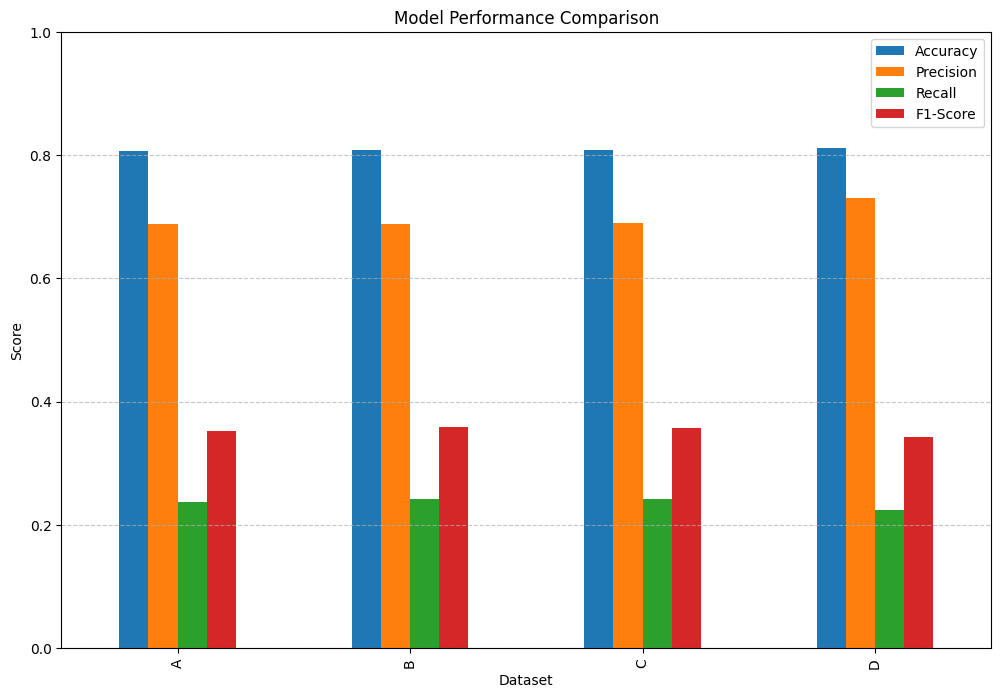

In [15]:
results_df.plot(kind="bar", figsize=(12,8))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


While F1-Scores are very close, df_B has a slight edge over the others, followed by C, A, D respectively.

In imbalanced datasets such as the credit card fraud detection, metrics like accuracy become misleading(as also seen in earlier assignments) Hence it is important to get the F1-Score : This focuses on how well the model identifies frauds(i.e. the minority class)

### Efficacy Discussion:
 

#### Listwise Deletion vs Imputation:

Listwise Deletion (Model D) completely removes every record that contains missing values.
While this approach simplifies preprocessing, it reduces the dataset size and can introduce bias if the missingness is not completely at random (MCAR).

In this dataset, missing values were introduced under a Missing At Random (MAR) mechanism—meaning the probability of missingness depends on observed features.
By deleting such rows, Model D discarded valuable, non-random information.

This explains why Model D achieved a slightly higher precision (0.73) but lower recall (0.22):

The model became overly conservative, predicting fewer defaults correctly.

Reduced data diversity limited its ability to generalize.

Consequently, its F1-score (0.34) was lower than those of the imputed models, indicating poorer overall performance despite a small bump in accuracy.

In contrast, Models A–C retained all records, preserving sample size and feature relationships. Even if the imputations introduced some noise, the classifier benefited from having more complete, information-rich data.

#### Linear vs Non-Linear Imputation

Both regression-based imputations (Models B and C) produced nearly identical results:

F1-score:  ~0.358 

Accuracy:  ~0.808
(for both)

Precision and Recall differed by less than 0.001

This suggests that the relationship between the imputed feature(s) and other predictors is primarily linear.
Non-linear models (e.g., Random Forest or KNN regressors) generally outperform when the missing feature has complex, non-monotonic dependencies.

However, in structured financial data like credit limits, bill amounts, and payment history, relationships tend to be approximately linear — e.g., higher income and age often correspond proportionally to higher credit limits and lower default risk.

Therefore, the additional complexity of the non-linear regressor did not yield measurable improvement; the linear regression imputation was sufficient.

#### Final Recommendation:

In this scenario, **Linear Regression Imputation (Model B)** is the optimal strategy.
It preserves all samples, respects underlying correlations, and performs comparably or better than more complex methods.
While Listwise Deletion appears slightly more accurate, its reduced recall and information loss make it less reliable for credit-risk prediction — a domain where identifying true defaulters (recall) is crucial.
